<h3>Reddit Survey Assignment</h3>

In [480]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [481]:
# While aggregating the continent information onto the sheet, the csv format was updated so that the following series
# un14 till un19 automatically got removed. Hence, they are not present in the sampling shown below.
X = pd.read_csv("RedditShortDemoSurvey-1-Cleaned.csv")

In [482]:
X.head(n=1)

,Entry Id,Please indicate your gender.,Please select the category that includes your age.,What is your marital status?,What best describes your employment status?,Are you or have you ever been in military service?,Do you currently have children under the age of 18 living in your household?,What best describes your level of education?,Treated country data,(For U. S. redditors) In which state do you live?,Which one of the following ranges includes your total yearly household income before taxes?,treated subreddit data,Are you a dog or a cat person?,"If you were a cheese, what cheese would you be?",Country Code,Continent
0,1,Male,25-34,Blank,Employed full time,none,No,Bachelor's degree,UNITED STATES,New York,"$150,000 or more",getmotivated,none,none,US,North America


In [483]:
# Shorten the column names
X.columns = ['ID', 'Sex', 'AgeCat', 'MarStat', 'EmpStat', 'Military', 'Chdlt18', 'Edu', 'Cntry', 'State', 'Income', 'SubReddit', 'DogorCat', 'Cheese', 'CntCd', 'Cont']

In [484]:
X.head(n=1)

,ID,Sex,AgeCat,MarStat,EmpStat,Military,Chdlt18,Edu,Cntry,State,Income,SubReddit,DogorCat,Cheese,CntCd,Cont
0,1,Male,25-34,Blank,Employed full time,none,No,Bachelor's degree,UNITED STATES,New York,"$150,000 or more",getmotivated,none,none,US,North America


In [485]:
X = X.drop(['ID', 'State'], axis=1)

<h4>Data Cleansing - Gender feature</h4>

In [486]:
X[X.Sex.isnull()]

,Sex,AgeCat,MarStat,EmpStat,Military,Chdlt18,Edu,Cntry,Income,SubReddit,DogorCat,Cheese,CntCd,Cont


In [487]:
X.Sex.value_counts()

Male      26418
Female     6135
None        201
Name: Sex, dtype: int64

In [488]:
# We need to handle the scenarios where Sex as been mentioned as "None". For this, we analyze the breakup of
# "Marital Status" feature for such scenarios.
X[X.Sex=="None"]['MarStat'].value_counts()

Forever Alone                               78
In a relationship                           46
Single                                      45
Married/civil union/domestic partnership    27
Engaged                                      5
Name: MarStat, dtype: int64

In [489]:
X[X.MarStat=='Forever Alone']['Sex'].value_counts()

Male      5086
Female     686
None        78
Name: Sex, dtype: int64

In [490]:
X[X.MarStat=='In a relationship']['Sex'].value_counts()

Male      7363
Female    2419
None        46
Name: Sex, dtype: int64

In [491]:
X[X.MarStat=='Single']['Sex'].value_counts()

Male      8672
Female    1711
None        45
Name: Sex, dtype: int64

In [492]:
X[X.MarStat=='Married/civil union/domestic partnership']['Sex'].value_counts()

Male      4441
Female    1022
None        27
Name: Sex, dtype: int64

In [493]:
X[X.MarStat=='Engaged']['Sex'].value_counts()

Male      826
Female    278
None        5
Name: Sex, dtype: int64

In [494]:
# It's evident that Males form the majority in the above Marital Status breakups. Hence, we set all the instances
# where Sex = "None" to "Male"
def setMale(x):
    if x == "None":
        return "Male"
    else:
        return x
X['Sex'] = X['Sex'].map(setMale)

In [495]:
X.Sex.value_counts()

Male      26619
Female     6135
Name: Sex, dtype: int64

<h4>Data Cleansing - Age Category feature</h4>

In [496]:
X.AgeCat.value_counts()

18-24          15802
25-34          11575
Under 18        2330
35-44           2257
45-54            502
55-64            140
None              88
65 or Above       60
Name: AgeCat, dtype: int64

In [497]:
X[X.AgeCat=="None"]['MarStat'].value_counts()

Forever Alone                               56
Single                                      18
In a relationship                            8
Engaged                                      3
Married/civil union/domestic partnership     3
Name: MarStat, dtype: int64

In [498]:
X[X.MarStat=="Forever Alone"]['AgeCat'].value_counts()

18-24          3153
25-34          1527
Under 18        797
35-44           236
45-54            57
None             56
55-64            12
65 or Above      12
Name: AgeCat, dtype: int64

In [499]:
X[X.MarStat=="Single"]['AgeCat'].value_counts()

18-24          6313
25-34          2558
Under 18       1062
35-44           357
45-54            78
55-64            26
None             18
65 or Above      16
Name: AgeCat, dtype: int64

In [500]:
X[X.MarStat=="In a relationship"]['AgeCat'].value_counts()

18-24          5545
25-34          3504
Under 18        455
35-44           248
45-54            54
None              8
55-64             7
65 or Above       7
Name: AgeCat, dtype: int64

In [501]:
X[X.MarStat=="Engaged"]['AgeCat'].value_counts()

25-34          674
18-24          351
35-44           68
Under 18         6
45-54            4
None             3
65 or Above      2
55-64            1
Name: AgeCat, dtype: int64

In [502]:
X[X.MarStat=="Married/civil union/domestic partnership"]['AgeCat'].value_counts()

25-34          3296
35-44          1344
18-24           431
45-54           306
55-64            88
65 or Above      16
Under 18          6
None              3
Name: AgeCat, dtype: int64

In [503]:
# Forever Alone, Single, In a relationship - falls mostly into 18-24 &
# Engaged, Married/civil union/domestic partnership - falls mostly into 25-34
# However, there are only 3 observations each for AgeCat = "None" that fall into the second set above
# Set all the "none" values in AgeCat to 18-24
def setAgeCat(x):
    if x == "None":
        return "18-24"
    else:
        return x
X['AgeCat'] = X['AgeCat'].map(setAgeCat)

In [504]:
X.AgeCat.value_counts()

18-24          15890
25-34          11575
Under 18        2330
35-44           2257
45-54            502
55-64            140
65 or Above       60
Name: AgeCat, dtype: int64

<h4>Data Cleansing - Marital Status feature</h4>

In [505]:
X.MarStat.value_counts()

Single                                      10428
In a relationship                            9828
Forever Alone                                5850
Married/civil union/domestic partnership     5490
Engaged                                      1109
Widowed                                        44
Blank                                           5
Name: MarStat, dtype: int64

In [506]:
# Since there are only 5 instances of Blank in MarStat, we set it to the status that has the majority - "Single"
def setMarStat(x):
    if x == "Blank":
        return "Single"
    else:
        return x
X['MarStat'] = X['MarStat'].map(setMarStat)

In [507]:
X.MarStat.value_counts()

Single                                      10433
In a relationship                            9828
Forever Alone                                5850
Married/civil union/domestic partnership     5490
Engaged                                      1109
Widowed                                        44
Name: MarStat, dtype: int64

<h4>Data Cleansing - Employment Status feature</h4>

In [508]:
X.EmpStat.value_counts()

Employed full time                       14814
Student                                  12987
Not employed, but looking for work        2087
Freelance                                 1948
Not employed and not looking for work      682
None                                       151
Retired                                     85
Name: EmpStat, dtype: int64

In [509]:
X[X.EmpStat=="None"]['AgeCat'].value_counts()

18-24       87
25-34       42
Under 18     9
35-44        8
45-54        4
55-64        1
Name: AgeCat, dtype: int64

In [510]:
X[X.AgeCat=='18-24']['EmpStat'].value_counts()

Student                                  9456
Employed full time                       4324
Not employed, but looking for work       1145
Freelance                                 650
Not employed and not looking for work     224
None                                       87
Retired                                     4
Name: EmpStat, dtype: int64

In [511]:
# Since 18-24 makes up much of the EmpStat = "None" category, and most of the people in this range are students, we
# set the "None" EmpStat observations to "Student"
def setEmpStat(x):
    if x == "None":
        return "Student"
    else:
        return x
X['EmpStat'] = X['EmpStat'].map(setEmpStat)

In [512]:
X.EmpStat.value_counts()

Employed full time                       14814
Student                                  13138
Not employed, but looking for work        2087
Freelance                                 1948
Not employed and not looking for work      682
Retired                                     85
Name: EmpStat, dtype: int64

<h4>Data Cleansing - Military Service feature</h4>

In [513]:
X.Military.value_counts()

No      30526
Yes      2223
none        5
Name: Military, dtype: int64

In [514]:
# Since there are only 5 instances of none in Military, we set it to the status that has the majority - "No"
def setMilitary(x):
    if x == "none":
        return "No"
    else:
        return x
X['Military'] = X['Military'].map(setMilitary)

In [515]:
X.Military.value_counts()

No     30531
Yes     2223
Name: Military, dtype: int64

<h4>Data Cleansing - Have Child under the age of 18? feature</h4>

In [516]:
X.Chdlt18.value_counts()

No      27488
Yes      5047
None      219
Name: Chdlt18, dtype: int64

In [517]:
X[X.Chdlt18=="None"]['MarStat'].value_counts()

Forever Alone                               76
Single                                      56
In a relationship                           54
Married/civil union/domestic partnership    27
Engaged                                      5
Widowed                                      1
Name: MarStat, dtype: int64

In [518]:
X[X.MarStat=="Forever Alone"]['Chdlt18'].value_counts()

No      5055
Yes      719
None      76
Name: Chdlt18, dtype: int64

In [519]:
X[X.MarStat=="Single"]['Chdlt18'].value_counts()

No      9320
Yes     1057
None      56
Name: Chdlt18, dtype: int64

In [520]:
X[X.MarStat=="In a relationship"]['Chdlt18'].value_counts()

No      9019
Yes      755
None      54
Name: Chdlt18, dtype: int64

In [521]:
X[X.MarStat=="Married/civil union/domestic partnership"]['Chdlt18'].value_counts()

No      3067
Yes     2396
None      27
Name: Chdlt18, dtype: int64

In [522]:
# The majority of Chdlt18 values are "No" (we are not checking the last two Marital Statuses as the numbers are
# very low). Hence, set "No" for all observations with Chdlt18 = "None"
def setChdlt18(x):
    if x == "None":
        return "No"
    else:
        return x
X['Chdlt18'] = X['Chdlt18'].map(setChdlt18)

In [523]:
X.Chdlt18.value_counts()

No     27707
Yes     5047
Name: Chdlt18, dtype: int64

<h4>Data Cleansing - Education feature</h4>

In [524]:
X.Edu.value_counts()

Bachelor's degree                     11046
Some college                           9600
Graduate or professional degree        4722
High school graduate or equivalent     3272
Some high school                       1924
Associate degree                       1411
Trade or Vocational degree              635
None                                    144
Name: Edu, dtype: int64

In [525]:
X[X.Edu=="None"]['MarStat'].value_counts()

Forever Alone                               68
Single                                      38
In a relationship                           24
Married/civil union/domestic partnership    13
Engaged                                      1
Name: MarStat, dtype: int64

In [526]:
X[X.MarStat=="Forever Alone"]['Edu'].value_counts()

Some college                          1811
Bachelor's degree                     1493
High school graduate or equivalent     871
Some high school                       673
Graduate or professional degree        590
Associate degree                       221
Trade or Vocational degree             123
None                                    68
Name: Edu, dtype: int64

In [527]:
X[X.MarStat=="Single"]['Edu'].value_counts()

Some college                          3484
Bachelor's degree                     3215
High school graduate or equivalent    1261
Graduate or professional degree       1080
Some high school                       822
Associate degree                       376
Trade or Vocational degree             157
None                                    38
Name: Edu, dtype: int64

In [528]:
X[X.MarStat=="In a relationship"]['Edu'].value_counts()

Bachelor's degree                     3624
Some college                          3004
Graduate or professional degree       1408
High school graduate or equivalent     852
Associate degree                       397
Some high school                       352
Trade or Vocational degree             167
None                                    24
Name: Edu, dtype: int64

In [529]:
# Since the majority of the courses fall into either "Bachelors" or "Some College", we apply them 50/50 to all "Nones"
global edu_flip_sw
def setEdu(x):
    global edu_flip_sw
    if x == "None":
        edu_flip_sw *= -1
        if edu_flip_sw == 1:
            return "Bachelor's degree"
        else:
            return "Some college"
    else:
        return x
edu_flip_sw = 1
X['Edu'] = X['Edu'].map(setEdu)

In [530]:
X.Edu.value_counts()

Bachelor's degree                     11118
Some college                           9672
Graduate or professional degree        4722
High school graduate or equivalent     3272
Some high school                       1924
Associate degree                       1411
Trade or Vocational degree              635
Name: Edu, dtype: int64

<h4>Data Cleansing - Country & Continent (derived) features</h4>

In [531]:
# Cntry Analysis. This field was cleaned up outside ipython using excel, and now contains only 190 observations with
# value = "NONE". Once we fit a valid country information for these instances, we would remove the Cntry & CntCd
# (2 byte Country code used for deriving continent information) fields.
X[X.Cntry=="NONE"]['Cheese'].value_counts()

Munster      72
Other        24
Cheddar      23
Brie         16
Provolone    14
Goat         13
Swiss        12
Feta          8
Paneer        5
American      2
Limburger     1
Name: Cheese, dtype: int64

In [532]:
X[X.Cheese=="Munster"]['Cntry'].value_counts()

UNITED STATES         1449
NONE                    72
CANADA                  52
UNITED KINGDOM          29
IRELAND                 26
FRANCE                  14
GERMANY                 12
NEW ZEALAND              9
AUSTRALIA                9
INDIA                    7
FINLAND                  6
NETHERLANDS              6
SWEDEN                   6
MEXICO                   4
BELGIUM                  4
SOUTH KOREA              4
JAPAN                    4
ISRAEL                   4
PUERTO RICO              3
CHINA                    3
HONDURAS                 3
QATAR                    3
ROMANIA                  3
ITALY                    3
SINGAPORE                3
POLAND                   3
COLOMBIA                 2
SWITZERLAND              2
SPAIN                    2
RUSSIAN FEDERATION       2
BELARUS                  2
COSTA RICA               1
CZECH REPUBLIC           1
BRAZIL                   1
HONG KONG                1
PORTUGAL                 1
BULGARIA                 1
D

In [533]:
# Since maximum of "Munster" cheese people belong to US, we populate all "NONE" with "United States". Since Continent
# information correlates to Cntry, we set all the 190 instances of Continent to "North America"
X.Cont.value_counts()

North America    24376
Europe            5535
Oceania           1421
Asia               830
South America      281
Africa             119
Antarctica           2
Name: Cont, dtype: int64

In [534]:
len(X[X.Cont.isnull()])

190

In [535]:
X.Cont = X.Cont.fillna(value = "North America")

In [536]:
X.Cont.value_counts()

North America    24566
Europe            5535
Oceania           1421
Asia               830
South America      281
Africa             119
Antarctica           2
Name: Cont, dtype: int64

<h4>Data Cleansing - Are you a Dog or Cat Person? feature</h4>

In [537]:
# Dog or Cat person analysis. There is no specific trend observed here, hence, we distribute "dogs" and "cats" evenly
# the remaining groups. The two missing instances are set to "I love dogs".
X.DogorCat.value_counts()

I like dogs.       17149
I like cats.       11152
I like turtles.     4442
none                   5
askreddit              2
 Reddit.com            1
movies                 1
Name: DogorCat, dtype: int64

In [538]:
global dogcat_sw
def setDogCat(x):
    global dogcat_sw
    if x in ("I like turtles.", "none", "askreddit", " Reddit.com", "movies"):
        dogcat_sw *= -1
        if dogcat_sw == 1:
            return "I like dogs."
        else:
            return "I like cats."
    else:
        return x
dogcat_sw = 1
X['DogorCat'] = X['DogorCat'].map(setDogCat)

In [539]:
X.DogorCat = X.DogorCat.fillna(value = "I like dogs.")

In [540]:
X.DogorCat.value_counts()

I like dogs.    19376
I like cats.    13378
Name: DogorCat, dtype: int64

<h4>Data Cleansing - What kind of Cheese are you? feature</h4>

In [541]:
# Cheese Analysis
X.Cheese.value_counts()

Other            6562
Cheddar          6101
Brie             3742
Provolone        3454
Swiss            3214
Feta             2991
Goat             2516
Munster          1770
American         1438
Paneer            618
Limburger         337
none                5
 f7u12              2
1                   1
programming')       1
 awww               1
 Pics               1
Name: Cheese, dtype: int64

In [542]:
# there are only few invalid entries for cheese, and hence, we split them across "Other" and "Cheddar". There are no
# missing values for this feature.
global cheese_sw
def setCheese(x):
    global cheese_sw
    if x in ("none", " f7u12", "1", "programming')", " awww", " Pics"):
        cheese_sw *= -1
        if cheese_sw == 1:
            return "Other"
        else:
            return "Cheddar"
    else:
        return x
cheese_sw = 1
X['Cheese'] = X['Cheese'].map(setCheese)

In [543]:
X.Cheese.value_counts()

Other        6567
Cheddar      6107
Brie         3742
Provolone    3454
Swiss        3214
Feta         2991
Goat         2516
Munster      1770
American     1438
Paneer        618
Limburger     337
Name: Cheese, dtype: int64

<h4>Data Cleansing - Fix "none" entries in target feature - Income</h4>

In [544]:
# Before popping Income to the target variable, we need to fix the "none" entries (there are no missing entries here)
X.Income.value_counts()

Under $20,000          7892
$50,000 - $69,999      4133
$70,000 - $99,999      4101
$100,000 - $149,999    3522
$20,000 - $29,999      3206
$30,000 - $39,999      2904
$150,000 or more       2695
$40,000 - $49,999      2686
none                   1615
Name: Income, dtype: int64

In [545]:
X[X.Income=="none"]['AgeCat'].value_counts()

18-24          885
Under 18       333
25-34          278
35-44           85
45-54           27
55-64            6
65 or Above      1
Name: AgeCat, dtype: int64

In [546]:
X[X.Income=="Under $20,000"]['AgeCat'].value_counts()

18-24          5649
25-34          1521
Under 18        548
35-44           127
45-54            25
55-64            12
65 or Above      10
Name: AgeCat, dtype: int64

In [547]:
X[X.Income=="$20,000 - $29,999"]['AgeCat'].value_counts()

18-24          1744
25-34          1229
Under 18         97
35-44            96
45-54            21
55-64            11
65 or Above       8
Name: AgeCat, dtype: int64

In [548]:
X[X.Income=="$30,000 - $39,999"]['AgeCat'].value_counts()

18-24          1308
25-34          1305
35-44           128
Under 18        109
45-54            31
55-64            19
65 or Above       4
Name: AgeCat, dtype: int64

In [549]:
X[X.Income=="$40,000 - $49,999"]['AgeCat'].value_counts()

25-34          1284
18-24          1082
35-44           149
Under 18        126
45-54            30
55-64            10
65 or Above       5
Name: AgeCat, dtype: int64

In [550]:
# Since Income distribution is spread mostly across "18-24" and "25-34", we set the "none" values to "Under 20k"
def setIncome(x):
    if x == "none":
        return "Under $20,000"
    else:
        return x
X['Income'] = X['Income'].map(setIncome)

In [551]:
X.Income.value_counts()

Under $20,000          9507
$50,000 - $69,999      4133
$70,000 - $99,999      4101
$100,000 - $149,999    3522
$20,000 - $29,999      3206
$30,000 - $39,999      2904
$150,000 or more       2695
$40,000 - $49,999      2686
Name: Income, dtype: int64

<h4>One final check before running the Regressor</h4>

In [552]:
# One final check on all the feature distributions, before model creation.
X.head(n=1)

,Sex,AgeCat,MarStat,EmpStat,Military,Chdlt18,Edu,Cntry,Income,SubReddit,DogorCat,Cheese,CntCd,Cont
0,Male,25-34,Single,Employed full time,No,No,Bachelor's degree,UNITED STATES,"$150,000 or more",getmotivated,I like cats.,Cheddar,US,North America


In [553]:
X.Sex.value_counts()

Male      26619
Female     6135
Name: Sex, dtype: int64

In [554]:
X.AgeCat.value_counts()

18-24          15890
25-34          11575
Under 18        2330
35-44           2257
45-54            502
55-64            140
65 or Above       60
Name: AgeCat, dtype: int64

In [555]:
X.MarStat.value_counts()

Single                                      10433
In a relationship                            9828
Forever Alone                                5850
Married/civil union/domestic partnership     5490
Engaged                                      1109
Widowed                                        44
Name: MarStat, dtype: int64

In [556]:
X.EmpStat.value_counts()

Employed full time                       14814
Student                                  13138
Not employed, but looking for work        2087
Freelance                                 1948
Not employed and not looking for work      682
Retired                                     85
Name: EmpStat, dtype: int64

In [557]:
X.Military.value_counts()

No     30531
Yes     2223
Name: Military, dtype: int64

In [558]:
X.Chdlt18.value_counts()

No     27707
Yes     5047
Name: Chdlt18, dtype: int64

In [559]:
X.Edu.value_counts()

Bachelor's degree                     11118
Some college                           9672
Graduate or professional degree        4722
High school graduate or equivalent     3272
Some high school                       1924
Associate degree                       1411
Trade or Vocational degree              635
Name: Edu, dtype: int64

In [560]:
# SubReddit isn't offering much insight, hence, we would be dropping it.
X.SubReddit.value_counts()

askreddit                                        2123
fffffffuuuuuuuuuuuu                              1746
pics                                             1651
trees                                            1311
gaming                                           1207
funny                                            1092
atheism                                           839
askscience                                        779
all                                               647
todayilearned                                     645
starcraft                                         611
iama                                              576
minecraft                                         520
f7u12                                             515
programming                                       501
twoxchromosomes                                   396
science                                           378
truereddit                                        347
wtf                         

In [561]:
X.DogorCat.value_counts()

I like dogs.    19376
I like cats.    13378
Name: DogorCat, dtype: int64

In [562]:
X.Cheese.value_counts()

Other        6567
Cheddar      6107
Brie         3742
Provolone    3454
Swiss        3214
Feta         2991
Goat         2516
Munster      1770
American     1438
Paneer        618
Limburger     337
Name: Cheese, dtype: int64

In [563]:
X.Cont.value_counts()

North America    24566
Europe            5535
Oceania           1421
Asia               830
South America      281
Africa             119
Antarctica           2
Name: Cont, dtype: int64

<h4>Drop unwanted features</h4>

In [564]:
# finally... drop unwanted features - Cntry, SubReddit and CntCd
X = X.drop(['Cntry', 'SubReddit', 'CntCd'], axis=1)

In [565]:
X.head(n=1)

,Sex,AgeCat,MarStat,EmpStat,Military,Chdlt18,Edu,Income,DogorCat,Cheese,Cont
0,Male,25-34,Single,Employed full time,No,No,Bachelor's degree,"$150,000 or more",I like cats.,Cheddar,North America


<h4>Pop the target feature into a different variable</h4>

In [566]:
y = X.pop('Income')
dummies = pd.get_dummies(y, prefix="Income")
y = pd.concat([y, dummies], axis=1)
y = y.drop("Income", axis=1)

In [567]:
X.describe()

,Sex,AgeCat,MarStat,EmpStat,Military,Chdlt18,Edu,DogorCat,Cheese,Cont
count,32754,32754,32754,32754,32754,32754,32754,32754,32754,32754
unique,2,7,6,6,2,2,7,2,11,7
top,Male,18-24,Single,Employed full time,No,No,Bachelor's degree,I like dogs.,Other,North America
freq,26619,15890,10433,14814,30531,27707,11118,19376,6567,24566


<h4>Implement one-hot encoding for all the categoricals</h4>

In [568]:
categorical_variables = ['Sex', 'AgeCat', 'MarStat', 'EmpStat', 'Military',
                         'Chdlt18', 'Edu', 'DogorCat', 'Cheese', 'Cont']
for variable in categorical_variables:
    dummies = pd.get_dummies(X[variable], prefix=variable)
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

<h4>Draw the seaborn plot that shows pair-wise correlation between features</h4>

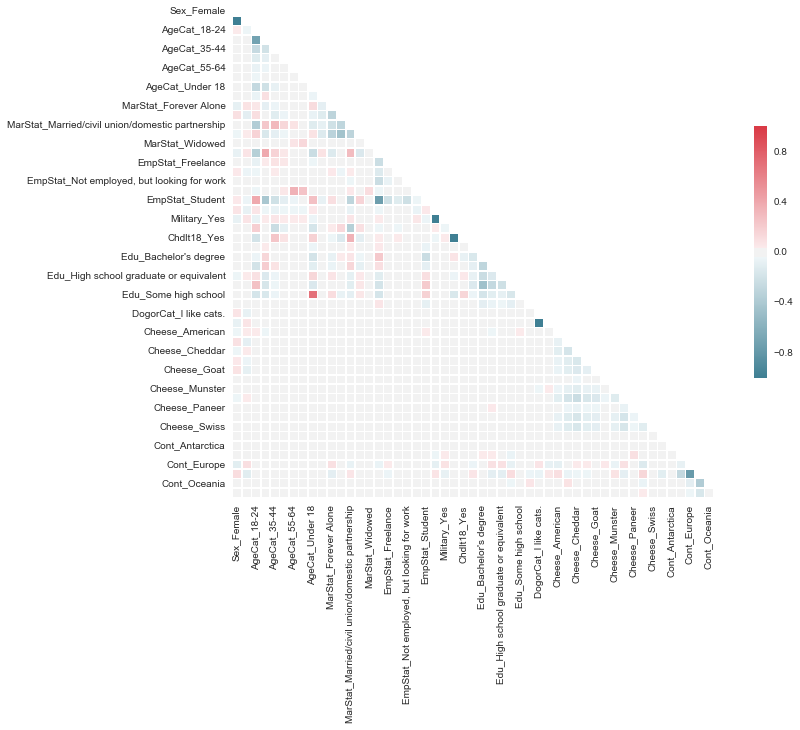

In [569]:
# The plot below is based on the hot-encoded variables, and not the actual features.
sns.set(style="white")

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [570]:
y.head(n=1)

,"Income_$100,000 - $149,999","Income_$150,000 or more","Income_$20,000 - $29,999","Income_$30,000 - $39,999","Income_$40,000 - $49,999","Income_$50,000 - $69,999","Income_$70,000 - $99,999","Income_Under $20,000"
0,0,1,0,0,0,0,0,0


<h4>Execute the RandomForest Classifier</h4>

In [571]:
model = RandomForestClassifier(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print "C-stat: ", roc_auc_score(y, model.predict(X))

C-stat:  0.67617968757


<h4>Execute the RandomForest Regressor</h4>

In [579]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
yhat = model.predict(X)
print "C-stat: ", roc_auc_score(y, yhat)

C-stat:  0.922098278892


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


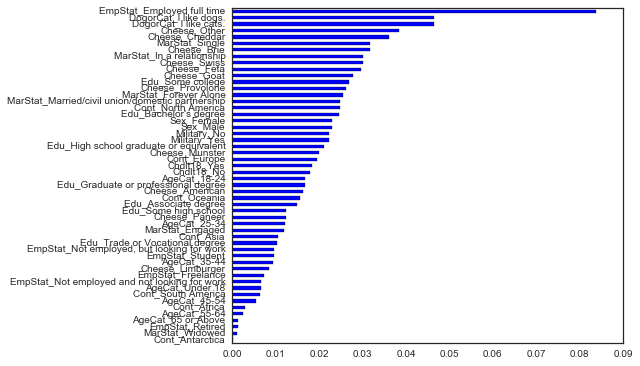

In [573]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6));

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


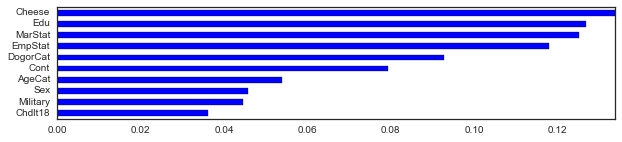

In [575]:
# Complex version that shows the summary view

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Mike Bernico
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)